# KNeighbors for Image Data

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. 

More info: http://yann.lecun.com/exdb/mnist/

## Preliminaries

### Imports

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier,DistanceMetric

%matplotlib inline
import gzip

import sys
sys.path.append("../..")
from E4525_ML import mnist
from E4525_ML import plots

### Random Seed

In [2]:
seed=23562
np.random.seed(seed)

### MNIST Data

In [4]:
model_dir="../../data/models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [5]:
data_dir=r"../../raw/MNIST/"

In [6]:
    images_filename=data_dir+"train-images-idx3-ubyte.gz"
    labels_filename=data_dir+"train-labels-idx1-ubyte.gz"

    test_images_filename=data_dir+"t10k-images-idx3-ubyte.gz"
    test_labels_filename=data_dir+"t10k-labels-idx1-ubyte.gz"

    images=mnist.read_images(images_filename)
    labels=mnist.read_labels(labels_filename)
    
    print(images.shape,labels.shape)

(60000, 28, 28) (60000,)


In [7]:
nimages=images.shape[0]
nrows=images.shape[1]
ncols=images.shape[2]
print(nimages,nrows,ncols)

60000 28 28


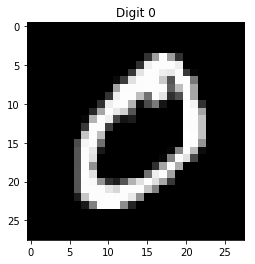

In [8]:
label=int(labels[1])
plt.title('Digit {0}'.format(label))
plt.imshow(images[1], cmap='gray')

## Train KNeighbors Classifier

Given a image represented as matrices of pixel values $f_{r,c}$ where sample  $r=1,\dots,R$ is the row index withing the image and $c=1,\dots,C $ is the column index, our **feature** vector will be
the linearization of the image 
$$
    x_{r*C+c} = f{r,c}
$$

Euclidean distance in this space is defined by

$$
    D(x,x') = \sum_d (x_{d}-x_{d}')^2.
$$

Each dimension $d$ represents one pixel on the image.

Each Pixel is treated independently, there is no concept of **space** locality on this definition of distance. Two images that differ by two pixel have the same distance no matter were those pixels are located.

Our input data is an array of images $F_{i,r,c}$, and our feature matrix will, thus be

$$
    X_{i,r*C+c}= F_{i,r,c}
$$

In [9]:
X=images.reshape((nimages,-1))
Y=labels
print(X.shape,Y.shape)
    

(60000, 784) (60000,)


We will use the nearest neighbor

In [10]:
K=1

In [11]:
model=KNeighborsClassifier(K)

In [12]:
model.fit(X,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

## Test KNeigbors Classifier

In [13]:
images_test=mnist.read_images(test_images_filename)
labels_test=mnist.read_labels(test_labels_filename)
X_test=images_test
Y_test=labels_test

Let's predict one image

In [14]:
label=Y_test[0]
predicted_label=model.predict(X_test[0].reshape(1,-1))
print(label,predicted_label)

7 [7]


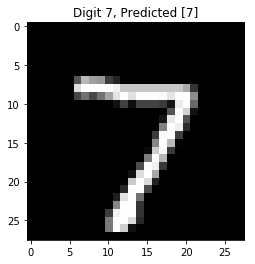

In [15]:
plt.title('Digit {0}, Predicted {1}'.format(label,predicted_label))
plt.imshow(images_test[0], cmap='gray')

Let's predict the full test sample $10,000$ images, this will be **slow**

In [16]:
nimages=X_test.shape[0]
X_test=X_test.reshape((nimages,-1))
print("predicting...",end="")
Y_predicted=model.predict(X_test)
print("Done.")

predicting...Done.


Prediction accuracy is **very good**, but the model is **very slow**, because we need to compare against every training sample.

In [17]:
accuracy=(Y_predicted==Y_test).sum() / len(Y_test)
print(f"accurancy = {accuracy}")

accurancy = 0.9691


Let's look at the confusion matrix    

In [18]:
classes=np.unique(Y)

Confusion matrix, without normalization
[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1129    3    0    1    1    1    0    0    0]
 [   7    6  992    5    1    0    2   16    3    0]
 [   0    1    2  970    1   19    0    7    7    3]
 [   0    7    0    0  944    0    3    5    1   22]
 [   1    1    0   12    2  860    5    1    6    4]
 [   4    2    0    0    3    5  944    0    0    0]
 [   0   14    6    2    4    0    0  992    0   10]
 [   6    1    3   14    5   13    3    4  920    5]
 [   2    5    1    6   10    5    1   11    1  967]]


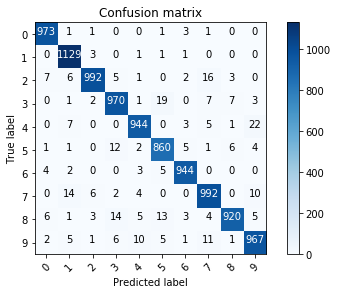

In [19]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_predicted)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

### Save model for later use

In [20]:
model_filename=model_dir+"/MNIST_KNeighbors.p"
file=open(model_filename,"wb")
pickle.dump(model,file)

## Shifted Test Sample

A feature of images is that shifting it to the rigth/left, or up/down should not
affect is classification label.

We can test with randomly shifted data

In [21]:
def roll(image,max_x=4,max_y=4):
    shiftx=np.random.randint(-max_x,max_x)
    shifty=np.random.randint(-max_y,max_y)
    image=np.roll(image,[shiftx,shifty],[0,1])
    return image

In [22]:
idx=0

In [23]:
img1=roll(images_test[idx])
label=labels_test[idx]

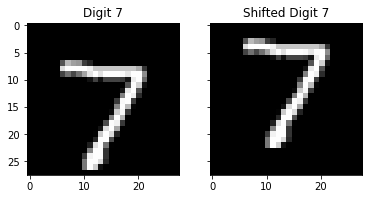

In [24]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Digit {0}'.format(label))
ax1.imshow(images_test[idx], cmap='gray')
ax2.set_title('Shifted Digit {0}'.format(label))
ax2.imshow(img1, cmap='gray')


Let's shift the whole test sample and predict again

In [25]:
shifted_images_test=np.empty_like(images_test)
for i in range(len(images_test)):
    shifted_images_test[i]=roll(images_test[i])
    

We can still predict

In [26]:
print(model.predict(shifted_images_test[idx].reshape(1,-1)),labels_test[idx])

[7] 7


But what is the overall accuracy?

In [27]:
nimages=shifted_images_test.shape[0]
X_test=shifted_images_test.reshape((nimages,-1))
print("predicting...",end=" ")
Y_predicted=model.predict(X_test)
print("Done.")

predicting... Done.


**Much worse**!

In [28]:
accuracy=(Y_predicted==Y_test).sum() / len(Y_test)
print(f"accurancy = {accuracy}")

accurancy = 0.4707


Confusion matrix, without normalization
[[338  52 193  18  63  43 133  80  23  37]
 [ 13 578  48   9 139  60 143 126  17   2]
 [ 46  47 636  36  79  14  47 108  10   9]
 [ 38  57 134 506  11 138  33  48  22  23]
 [ 11 228  29  15 494  33  56  73   4  39]
 [ 16  21  81  93  13 508  51  37  32  40]
 [ 48  68  47  15 131  68 520   7  17  37]
 [ 14 213 110  23  41  21  11 552   1  42]
 [ 19  70  75  80  29 122 148  68 295  68]
 [ 32 208  35  20 119  77  21 203  14 280]]


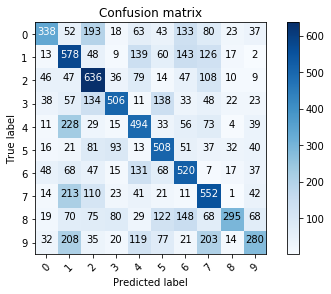

In [29]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_predicted)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

1. We can train with shifted data to resolve the issue
2. But that would multiply the number of samples and make the slowness even worse.
3. Nearest Neighbors **does not scale** well with the complexity of the model.
4. We will build more sophisticated models later on the course to handle this issue.